# Some integration tests for biologically plausible winner-take-all algorithm (`BioWTARegressor`)

In [1]:
%matplotlib inline
import time
import timeit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from types import SimpleNamespace
from typing import Sequence, Callable
from tqdm.notebook import tqdm

from bioslds.arma_hsmm import ArmaHSMM, sample_switching_models
from bioslds.arma import make_random_arma, Arma
from bioslds.regressors import BioWTARegressor, fit_infer_ar
from bioslds import sources
from bioslds.plotting import FigureManager, show_latent

## Check performance on pure regression problem

In [2]:
rng = np.random.default_rng(0)

pure_reg = SimpleNamespace(n_samples=30_000, n_features=4, n_models=2, streak_len=1000)
pure_reg.models = []
pure_reg.predictors = rng.normal(size=(pure_reg.n_samples, pure_reg.n_features))
pure_reg.noise = 0.0 * rng.normal(size=(pure_reg.n_samples))
pure_reg.usage_seq = (np.arange(pure_reg.n_samples) / pure_reg.streak_len).astype(int) % pure_reg.n_models
pure_reg.seq0 = np.zeros(pure_reg.n_samples)
for i in range(pure_reg.n_models):
    crt_model = rng.normal(size=pure_reg.n_features)
    pure_reg.models.append(crt_model)
    
    mask = pure_reg.usage_seq == i
    pure_reg.seq0[mask] = pure_reg.predictors[mask, :] @ crt_model

pure_reg.seq = pure_reg.seq0 + pure_reg.noise

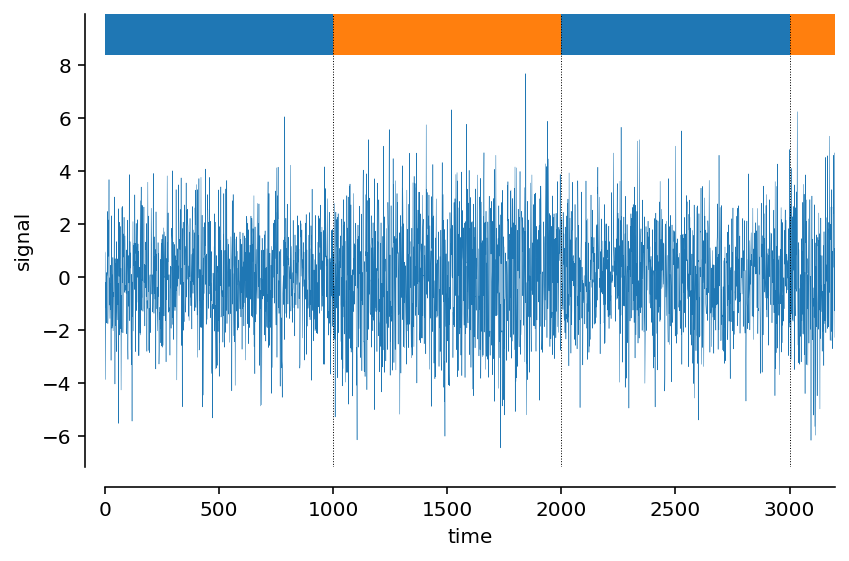

In [3]:
with FigureManager() as (_, ax):
    ax.plot(pure_reg.seq[:3200], lw=0.25)
    ax.set_xlim(0, 3200)
    show_latent(pure_reg.usage_seq)
    
    ax.set_xlabel("time")
    ax.set_ylabel("signal")

In [4]:
pure_reg.regressor = BioWTARegressor(pure_reg.n_models, pure_reg.n_features)
pure_reg.inferred_r = pure_reg.regressor.fit_infer(pure_reg.predictors, pure_reg.seq)
pure_reg.inferred_usage = np.argmax(pure_reg.inferred_r, axis=1)

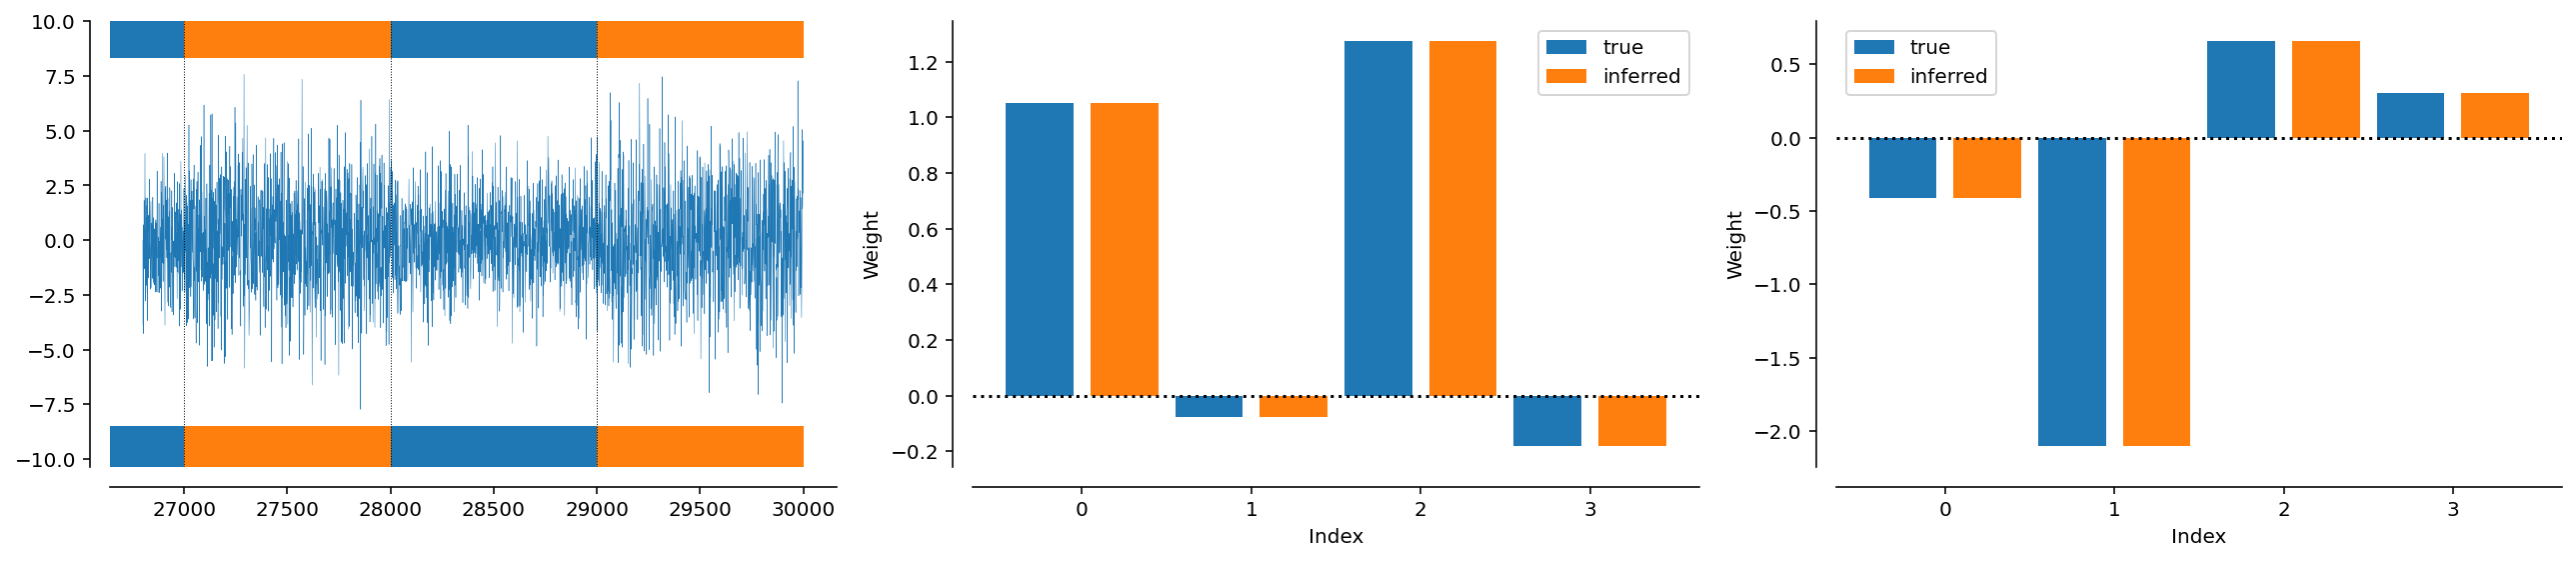

In [5]:
with FigureManager(1, pure_reg.n_models + 1) as (_, axs):
    axs[0].plot(
        np.arange(pure_reg.n_samples - 3200, pure_reg.n_samples),
        pure_reg.seq[-3200:],
        lw=0.25
    )
    show_latent(pure_reg.inferred_usage, show_vlines=False, ax=axs[0])
    show_latent(pure_reg.usage_seq, bar_location="bottom", ax=axs[0])
    
    used_models = set()
    for i in range(pure_reg.n_models):
        ax = axs[i + 1]
        
        crt_model = pure_reg.models[i]
        
        # find fitted model that best matches the real model
        crt_corrs = -np.inf * np.ones(pure_reg.n_models)
        for k in range(pure_reg.n_models):
            if k in used_models:
                continue
            crt_corrs[k] = np.corrcoef(crt_model, pure_reg.regressor.weights_[k])[0, 1]
        
        i_match = crt_corrs.argmax()
        used_models.add(i_match)
        
        ax.bar(np.arange(pure_reg.n_features) - 0.25, crt_model, width=0.4, label="true")
        ax.bar(
            np.arange(pure_reg.n_features) + 0.25,
            pure_reg.regressor.weights_[i_match],
            width=0.4,
            label="inferred"
        )
        ax.axhline(0, c="k", ls=":")
        
        ax.legend()
        ax.set_xticks(np.arange(pure_reg.n_features))
        
        ax.set_xlabel("Index")
        ax.set_ylabel("Weight")

## Check performance on randomly switching AR(3)s

In [6]:
rng = np.random.default_rng(1)

two_ar3 = SimpleNamespace(
    arma1=make_random_arma(3, 0, rng, default_source=sources.GaussianNoise(1)),
    arma2=make_random_arma(3, 0, rng, default_source=sources.GaussianNoise(2)),
    n_samples=100_000,
    n_features=3,
)
two_ar3.models = [two_ar3.arma1, two_ar3.arma2]
two_ar3.arma_hsmm = ArmaHSMM(two_ar3.models, min_dwell=15, dwell_times=50,)
two_ar3.n_models = len(two_ar3.models)

(two_ar3.sig, two_ar3.u, two_ar3.usage_seq,) = two_ar3.arma_hsmm.transform(
    two_ar3.n_samples
)

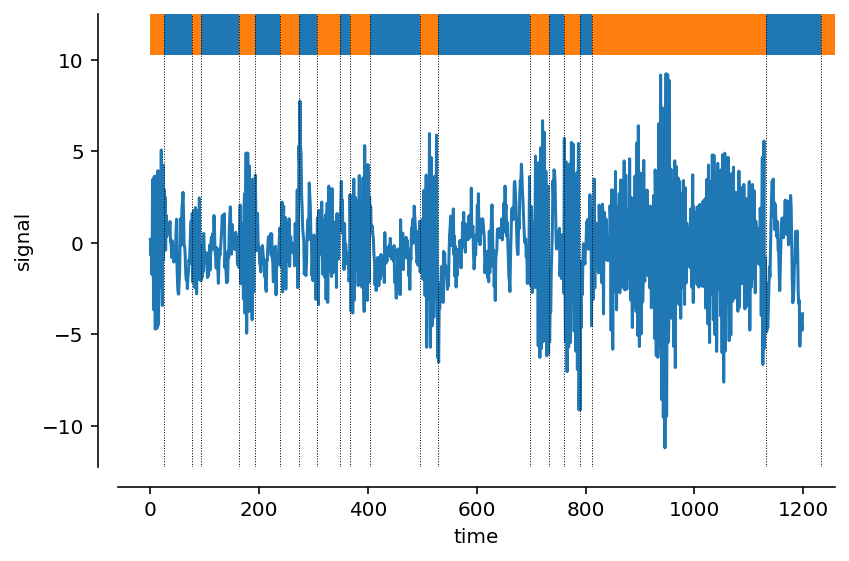

In [7]:
with FigureManager() as (_, ax):
    ax.plot(two_ar3.sig[:1200])
    ax.set_xlabel("time")
    ax.set_ylabel("signal")
    
    show_latent(two_ar3.usage_seq, ax=ax)    

In [8]:
two_ar3.regressor = BioWTARegressor(two_ar3.n_models, two_ar3.n_features)
two_ar3.inferred_r, two_ar3.history = fit_infer_ar(
    two_ar3.regressor,
    two_ar3.sig,
    progress=tqdm,
    return_history=True,
)
two_ar3.inferred_usage = np.argmax(two_ar3.inferred_r, axis=1)

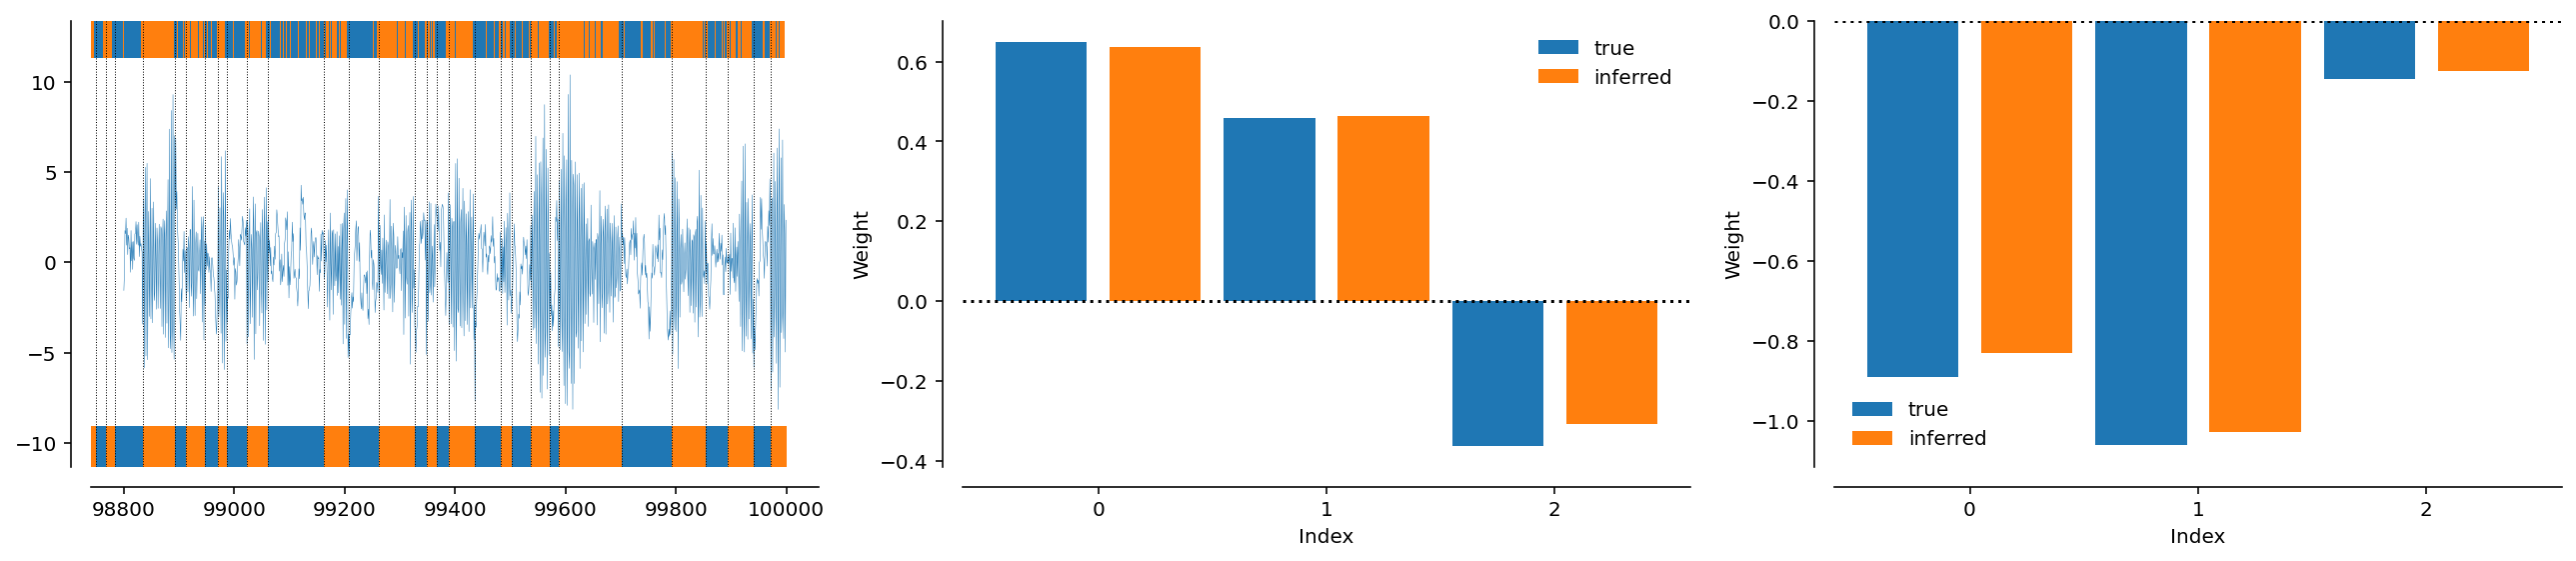

In [9]:
with FigureManager(1, two_ar3.n_models + 1) as (_, axs):
    axs[0].plot(
        np.arange(two_ar3.n_samples - 1200, two_ar3.n_samples),
        two_ar3.sig[-1200:],
        lw=0.25
    )
    show_latent(two_ar3.inferred_usage, show_vlines=False, ax=axs[0])
    show_latent(two_ar3.usage_seq, bar_location="bottom", ax=axs[0])
    
    used_models = set()
    for i in range(two_ar3.n_models):
        ax = axs[i + 1]
        
        crt_model = two_ar3.models[i].a
        
        # find fitted model that best matches the real model
        crt_corrs = -np.inf * np.ones(two_ar3.n_models)
        for k in range(two_ar3.n_models):
            if k in used_models:
                continue
            crt_corrs[k] = np.corrcoef(crt_model, two_ar3.regressor.weights_[k])[0, 1]
        
        i_match = crt_corrs.argmax()
        used_models.add(i_match)
        
        ax.bar(np.arange(two_ar3.n_features) - 0.25, crt_model, width=0.4, label="true")
        ax.bar(
            np.arange(two_ar3.n_features) + 0.25,
            two_ar3.regressor.weights_[i_match],
            width=0.4,
            label="inferred"
        )
        ax.axhline(0, c="k", ls=":")
        
        ax.legend(frameon=False)
        ax.set_xticks(np.arange(two_ar3.n_features))
        
        ax.set_xlabel("Index")
        ax.set_ylabel("Weight")

## Randomly switching AR(3)s with non-trivial latent Markov parameters

In [10]:
rng = np.random.default_rng(1)

two_ar3_bias_markov = SimpleNamespace(
    arma1=make_random_arma(3, 0, rng, default_source=sources.GaussianNoise(1)),
    arma2=make_random_arma(3, 0, rng, default_source=sources.GaussianNoise(2)),
    n_samples=100_000,
    n_features=3,
    regressor_expected_dwell=50,
)
two_ar3_bias_markov.models = [two_ar3_bias_markov.arma1, two_ar3_bias_markov.arma2]
two_ar3_bias_markov.arma_hsmm = ArmaHSMM(
    two_ar3_bias_markov.models, min_dwell=15, dwell_times=50,
)
two_ar3_bias_markov.n_models = len(two_ar3_bias_markov.models)

(
    two_ar3_bias_markov.sig,
    two_ar3_bias_markov.u,
    two_ar3_bias_markov.usage_seq,
) = two_ar3_bias_markov.arma_hsmm.transform(two_ar3_bias_markov.n_samples)

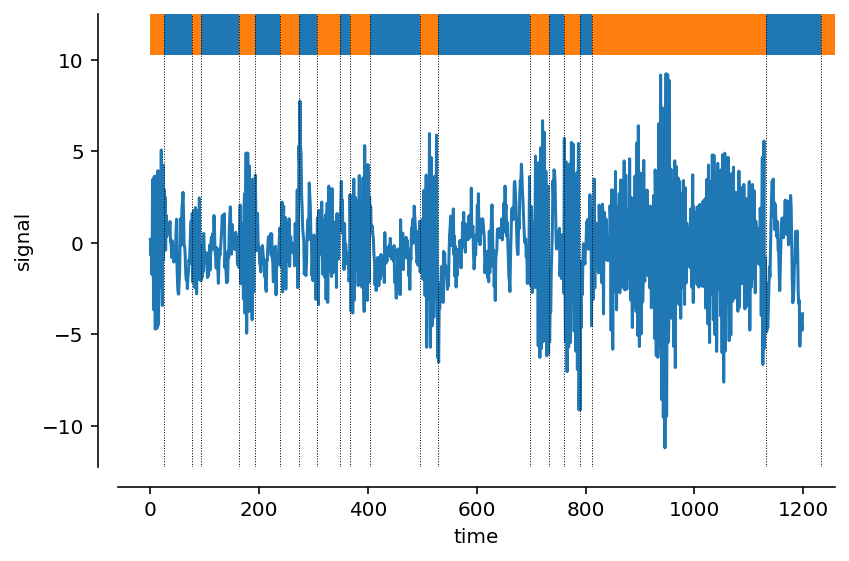

In [11]:
with FigureManager() as (_, ax):
    ax.plot(two_ar3_bias_markov.sig[:1200])
    ax.set_xlabel("time")
    ax.set_ylabel("signal")
    
    show_latent(two_ar3_bias_markov.usage_seq, ax=ax)    

In [12]:
two_ar3_bias_markov.regressor = BioWTARegressor(
    two_ar3_bias_markov.n_models,
    two_ar3_bias_markov.n_features,
    trans_mat=1 - 1 / two_ar3_bias_markov.regressor_expected_dwell,
)
two_ar3_bias_markov.inferred_r, two_ar3_bias_markov.history = fit_infer_ar(
    two_ar3_bias_markov.regressor,
    two_ar3_bias_markov.sig,
    progress=tqdm,
    return_history=True,
)
two_ar3_bias_markov.inferred_usage = np.argmax(two_ar3_bias_markov.inferred_r, axis=1)

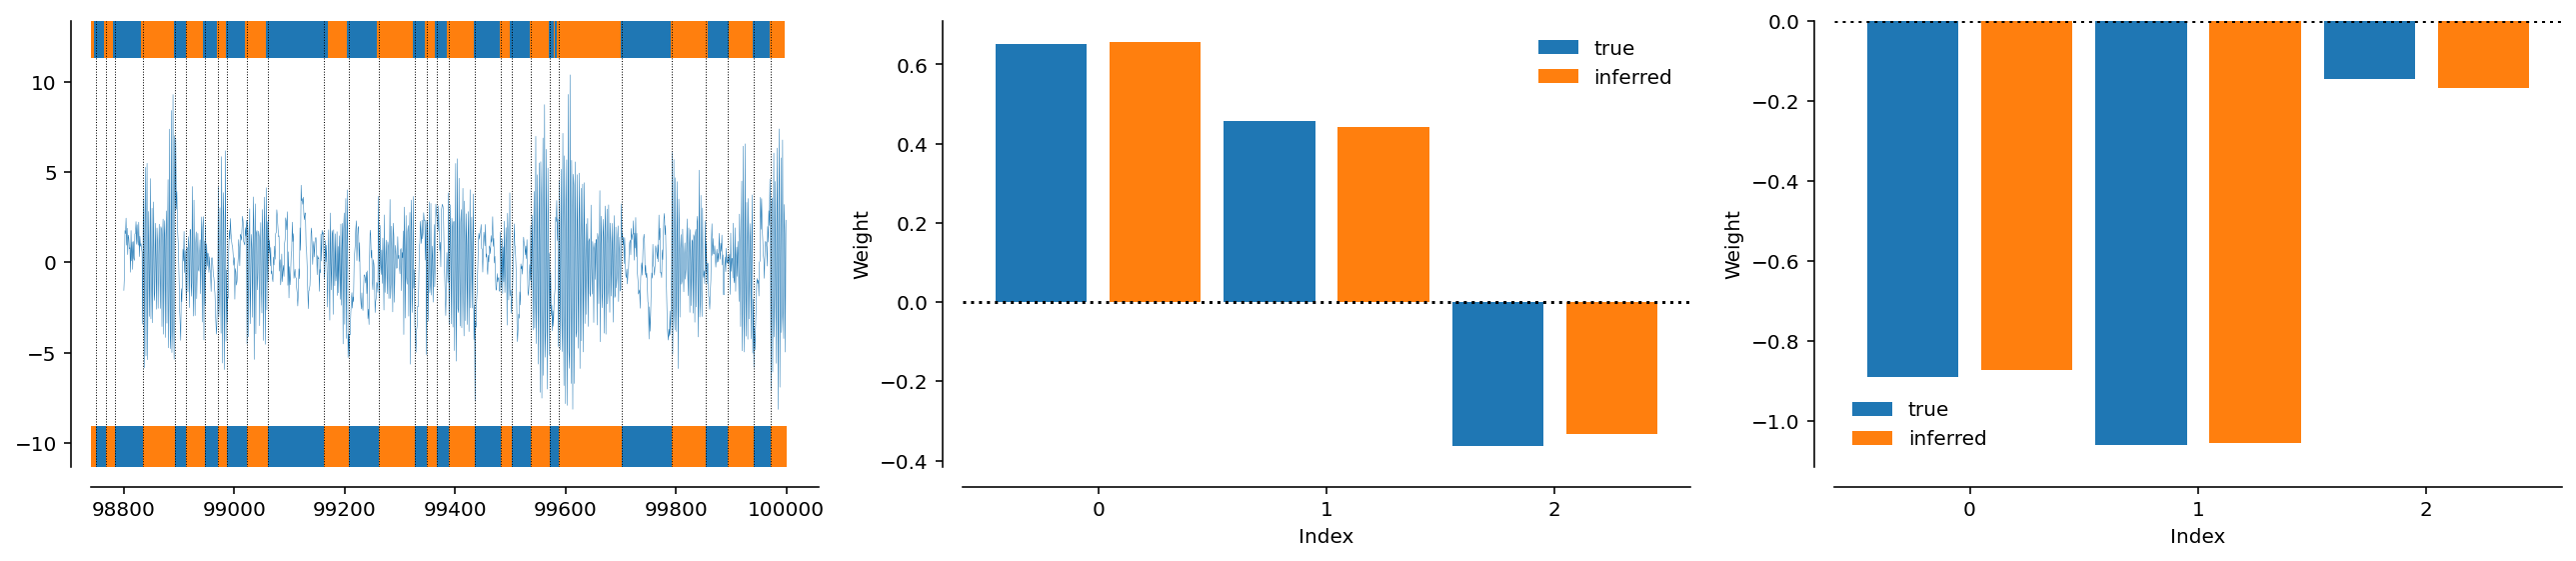

In [13]:
with FigureManager(1, two_ar3_bias_markov.n_models + 1) as (_, axs):
    axs[0].plot(
        np.arange(two_ar3_bias_markov.n_samples - 1200, two_ar3_bias_markov.n_samples),
        two_ar3_bias_markov.sig[-1200:],
        lw=0.25,
    )
    show_latent(two_ar3_bias_markov.inferred_usage, show_vlines=False, ax=axs[0])
    show_latent(two_ar3_bias_markov.usage_seq, bar_location="bottom", ax=axs[0])

    used_models = set()
    for i in range(two_ar3_bias_markov.n_models):
        ax = axs[i + 1]

        crt_model = two_ar3_bias_markov.models[i].a

        # find fitted model that best matches the real model
        crt_corrs = -np.inf * np.ones(two_ar3_bias_markov.n_models)
        for k in range(two_ar3_bias_markov.n_models):
            if k in used_models:
                continue
            crt_corrs[k] = np.corrcoef(
                crt_model, two_ar3_bias_markov.regressor.weights_[k]
            )[0, 1]

        i_match = crt_corrs.argmax()
        used_models.add(i_match)

        ax.bar(
            np.arange(two_ar3_bias_markov.n_features) - 0.25,
            crt_model,
            width=0.4,
            label="true",
        )
        ax.bar(
            np.arange(two_ar3_bias_markov.n_features) + 0.25,
            two_ar3_bias_markov.regressor.weights_[i_match],
            width=0.4,
            label="inferred",
        )
        ax.axhline(0, c="k", ls=":")

        ax.legend(frameon=False)
        ax.set_xticks(np.arange(two_ar3_bias_markov.n_features))

        ax.set_xlabel("Index")
        ax.set_ylabel("Weight")

## Check performance on AR(1)s with switching means

In [14]:
rng = np.random.default_rng(2)

three_ar1_nonzero_mean = SimpleNamespace(
    arma1=Arma([0.97], [], bias=1.0, default_source=sources.GaussianNoise(1)),
    arma2=Arma([0.97], [], bias=-1.0, default_source=sources.GaussianNoise(1)),
    arma3=Arma([0.97], [], bias=0.0, default_source=sources.GaussianNoise(1)),
    n_samples=600_000,
    n_features=1,
    streak_len=40,
)
three_ar1_nonzero_mean.models = [
    three_ar1_nonzero_mean.arma1,
    three_ar1_nonzero_mean.arma2,
    three_ar1_nonzero_mean.arma3
]
three_ar1_nonzero_mean.n_models = len(three_ar1_nonzero_mean.models)
three_ar1_nonzero_mean.usage_seq = np.repeat(
    (three_ar1_nonzero_mean.n_samples // (3 * three_ar1_nonzero_mean.streak_len)) * [0, 1, 2],
    three_ar1_nonzero_mean.streak_len
)
(
    three_ar1_nonzero_mean.sig,
    three_ar1_nonzero_mean.u,
) = sample_switching_models(three_ar1_nonzero_mean.models, three_ar1_nonzero_mean.usage_seq)

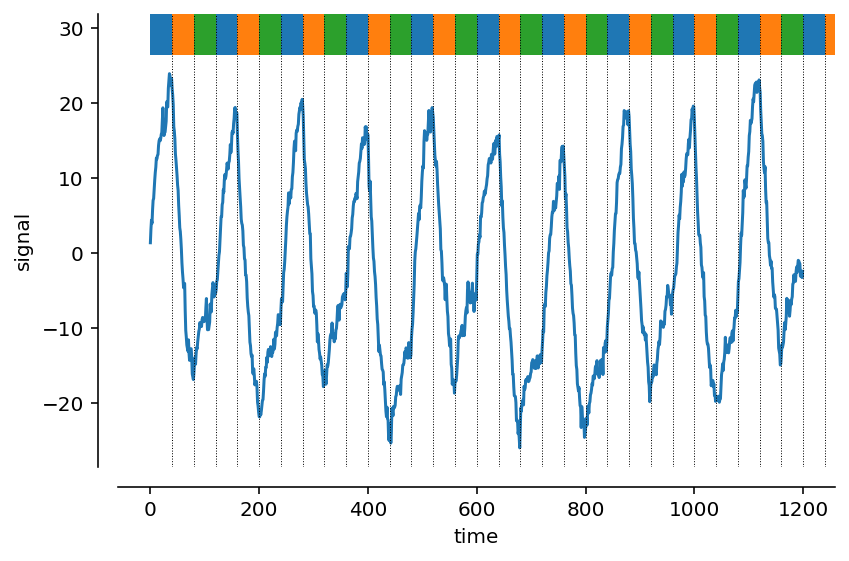

In [15]:
with FigureManager() as (_, ax):
    ax.plot(three_ar1_nonzero_mean.sig[:1200])
    ax.set_xlabel("time")
    ax.set_ylabel("signal")
    
    show_latent(three_ar1_nonzero_mean.usage_seq, ax=ax)    

In [16]:
three_ar1_nonzero_mean.regressor = BioWTARegressor(
    three_ar1_nonzero_mean.n_models,
    three_ar1_nonzero_mean.n_features + 1,  # +1 for bias
    rate_weights=0.001,
    trans_mat=0.9,
)
three_ar1_nonzero_mean.inferred_r, three_ar1_nonzero_mean.history = fit_infer_ar(
    three_ar1_nonzero_mean.regressor,
    three_ar1_nonzero_mean.sig,
    bias=True,
    progress=tqdm,
    return_history=True,
)
three_ar1_nonzero_mean.inferred_usage = np.argmax(three_ar1_nonzero_mean.inferred_r, axis=1)

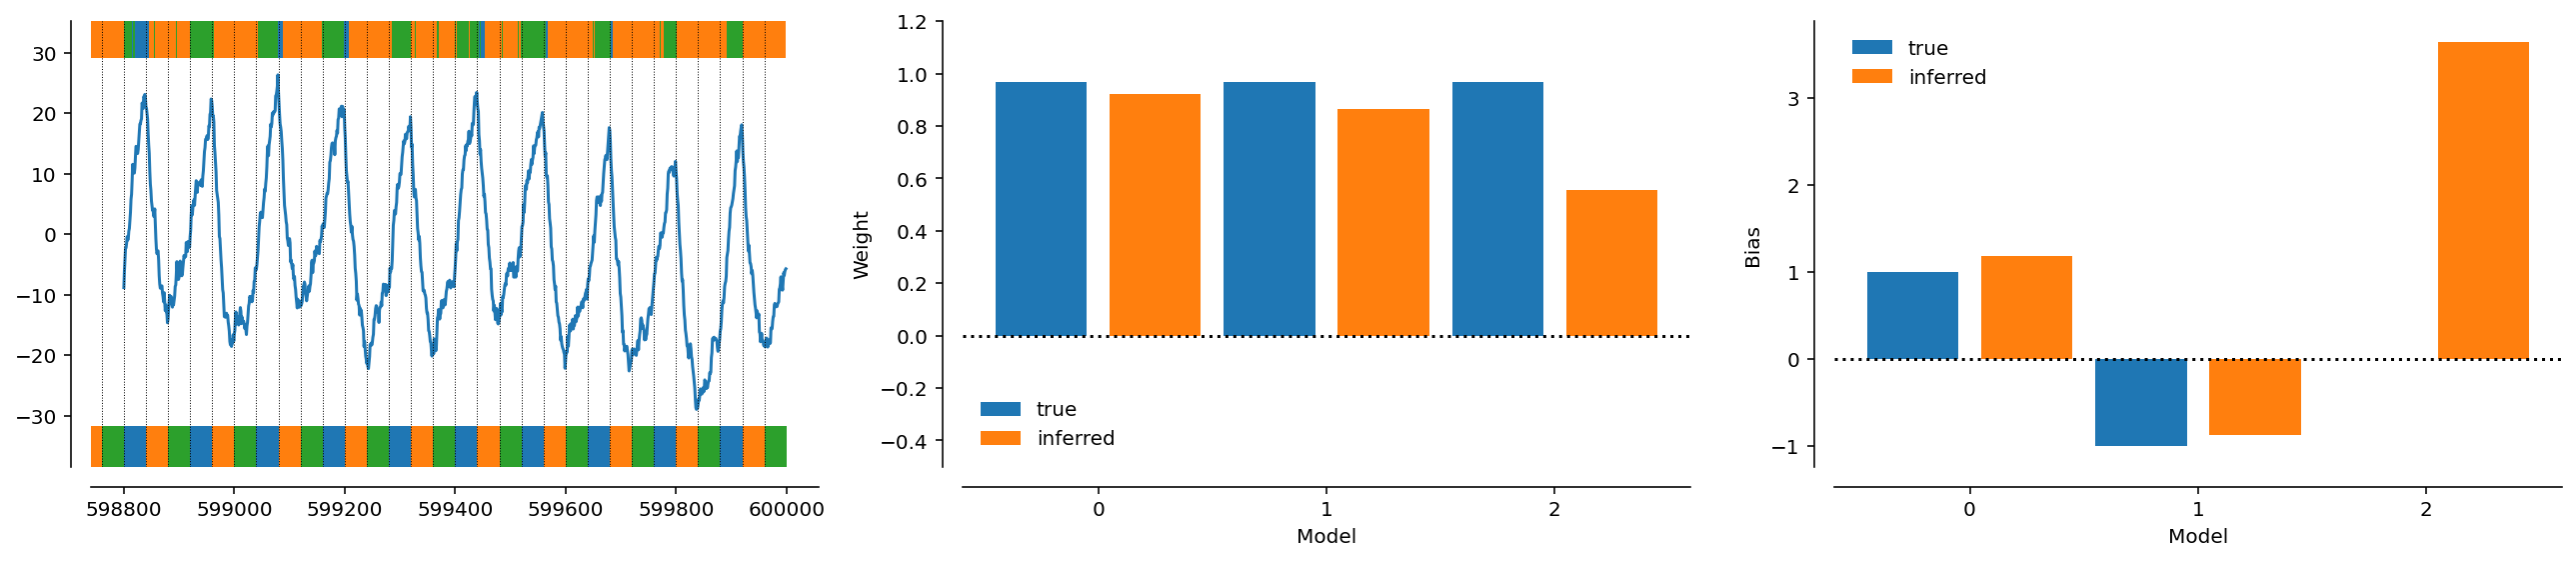

In [17]:
with FigureManager(1, 3) as (_, axs):
    axs[0].plot(
        np.arange(three_ar1_nonzero_mean.n_samples - 1200, three_ar1_nonzero_mean.n_samples),
        three_ar1_nonzero_mean.sig[-1200:],
    )
    show_latent(three_ar1_nonzero_mean.inferred_usage, show_vlines=False, ax=axs[0])
    show_latent(three_ar1_nonzero_mean.usage_seq, bar_location="bottom", ax=axs[0])
    
    i_matches = []
    for i in range(three_ar1_nonzero_mean.n_models):
        crt_model = [three_ar1_nonzero_mean.models[i].a[0], three_ar1_nonzero_mean.models[i].bias]
        
        # find fitted model that best matches the real model
        crt_corrs = np.inf * np.ones(three_ar1_nonzero_mean.n_models)
        for k in range(three_ar1_nonzero_mean.n_models):
            if k in i_matches:
                continue
            crt_corrs[k] = np.max(np.abs(crt_model - three_ar1_nonzero_mean.regressor.weights_[k]))
        
        i_match = crt_corrs.argmin()
        i_matches.append(i_match)
    
    # show AR weight
    axs[1].bar(
        np.arange(three_ar1_nonzero_mean.n_models) - 0.25,
        [_.a[0] for _ in three_ar1_nonzero_mean.models],
        width=0.4,
        label="true"
    )
    axs[1].bar(
        np.arange(three_ar1_nonzero_mean.n_models) + 0.25,
        three_ar1_nonzero_mean.regressor.weights_[i_matches, 0],
        width=0.4,
        label="inferred"
    )
        
    axs[1].axhline(0, c="k", ls=":")
        
    axs[1].legend(frameon=False)
    axs[1].set_xticks(np.arange(three_ar1_nonzero_mean.n_models))

    axs[1].set_xlabel("Model")
    axs[1].set_ylabel("Weight")
    
    axs[1].set_ylim(-0.5, 1.2)
    
    # show bias
    axs[2].bar(
        np.arange(three_ar1_nonzero_mean.n_models) - 0.25,
        [_.bias for _ in three_ar1_nonzero_mean.models],
        width=0.4,
        label="true"
    )
    axs[2].bar(
        np.arange(three_ar1_nonzero_mean.n_models) + 0.25,
        three_ar1_nonzero_mean.regressor.weights_[i_matches, 1],
        width=0.4,
        label="inferred"
    )
        
    axs[2].axhline(0, c="k", ls=":")
        
    axs[2].legend(frameon=False)
    axs[2].set_xticks(np.arange(three_ar1_nonzero_mean.n_models))

    axs[2].set_xlabel("Model")
    axs[2].set_ylabel("Bias")

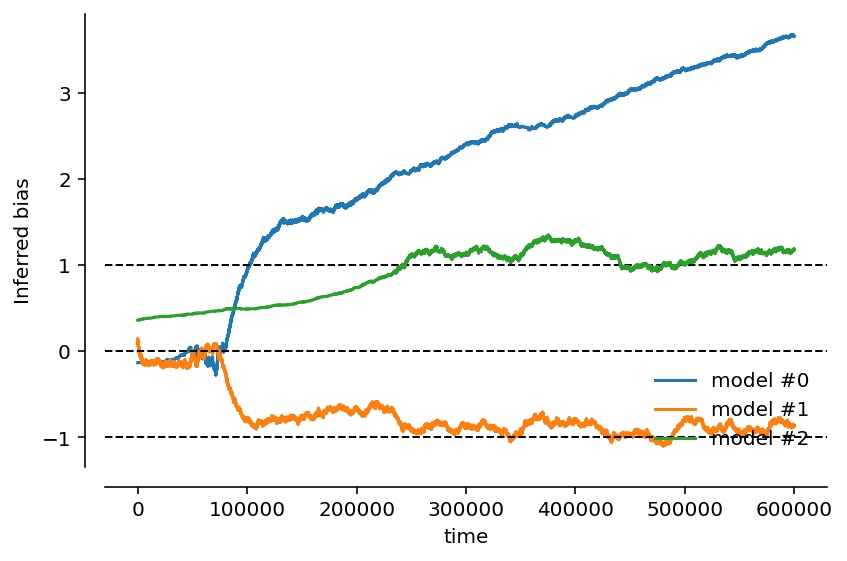

In [18]:
with FigureManager() as (_, ax):
    for i in range(three_ar1_nonzero_mean.n_models):
        ax.plot(three_ar1_nonzero_mean.history.weights[:, i, 1], label=f"model #{i}")
        ax.axhline(three_ar1_nonzero_mean.models[i].bias, c="k", ls="--", lw=1)
        
    ax.set_xlabel("time")
    ax.set_ylabel("Inferred bias")
    ax.legend(frameon=False, loc="lower right")

In [19]:
print("Regressor inferred weights:", three_ar1_nonzero_mean.regressor.weights_[:, 0])
print("Ground-truth:", np.asarray([_.a[0] for _ in three_ar1_nonzero_mean.models]))

Regressor inferred weights: [0.55646358 0.86451311 0.92258154]
Ground-truth: [0.97 0.97 0.97]


In [20]:
print("Regressor inferred biases:", three_ar1_nonzero_mean.regressor.weights_[:, 1])
print("Ground-truth:", np.asarray([_.bias for _ in three_ar1_nonzero_mean.models]))

Regressor inferred biases: [ 3.65299074 -0.86632448  1.18606221]
Ground-truth: [ 1. -1.  0.]


In [21]:
print(
    "Inferred model usage:",
    np.asarray(
        [np.mean(three_ar1_nonzero_mean.inferred_usage == _) for _ in range(three_ar1_nonzero_mean.n_models)]
    )
)

Inferred model usage: [0.21369536 0.60823768 0.17806696]


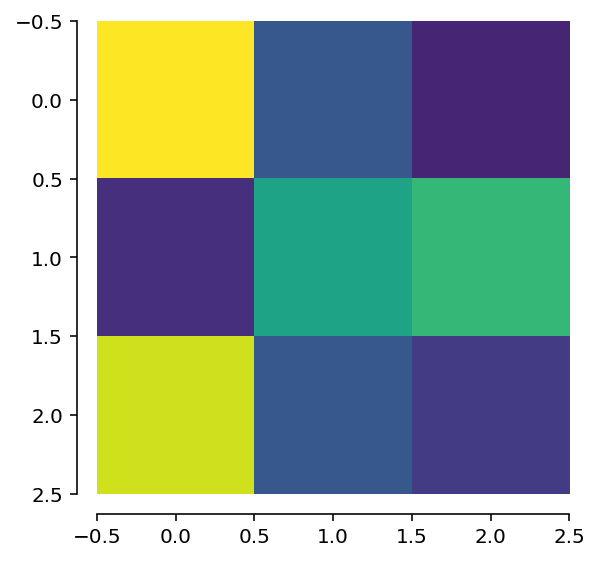

In [22]:
crt_contingency = np.zeros(
    (three_ar1_nonzero_mean.n_models, three_ar1_nonzero_mean.n_models)
)
for i in range(three_ar1_nonzero_mean.n_models):
    for j in range(three_ar1_nonzero_mean.n_models):
        crt_contingency[i, j] = np.mean(
            (three_ar1_nonzero_mean.inferred_usage == i) & (three_ar1_nonzero_mean.usage_seq[1:] == j)
        )
crt_contingency = crt_contingency / np.sum(crt_contingency, axis=1)[:, None]
with FigureManager() as (_, ax):
    ax.imshow(crt_contingency, vmin=0)

In [23]:
crt_contingency

array([[0.72455291, 0.19946653, 0.07598056],
       [0.09660987, 0.41994344, 0.48344668],
       [0.67242606, 0.19814676, 0.12942718]])